## Hansen & Singleton (1982)

O intuito deste trabalho é replicar o trabalho de Hansen, Lars Peter, and Kenneth J. Singleton. "Generalized instrumental variables estimation of nonlinear rational expectations models." Econometrica (1982): 1269-1286 com dados brasileiros de retorno do ibovespa, futuro DI de 1 mês representando o ativo livre de risco e consumo.

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm

from datetime import datetime, timedelta
import pandas_datareader.data as web
from calendar import monthrange

from scipy.optimize import minimize
from statsmodels.sandbox.regression import gmm

In [2]:
# criando um dataframe com as datas diárias e com frequência trimestral de 01/01/2000 até hoje
date_today = datetime.now().date()
days = pd.date_range(start = '2000-01-01', end = date_today, freq='D')
months = pd.date_range(start = '2012-06-30', end = date_today, freq='M')
quarters = pd.date_range(start = '2012-06-30', end = date_today, freq='Q')

In [3]:
# função que se a entrada for NaN toma o valor do dia anterior
def normalize_nan(df):
    for i in range(len(df)):
        if i == 0:
            pass
        elif math.isnan(df.iloc[i]) == True:
            df.iloc[i] = df.iloc[i-1]
        else:
            continue

In [4]:
# função que recebe código do BC e devolve uma série de acordo
# códigos e séries podem ser encontrados em https://www3.bcb.gov.br/sgspub/localizarseries/localizarSeries.do?method=prepararTelaLocalizarSeries
def consulta_bc(codigo_bcb):
  url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(codigo_bcb)
  df = pd.read_json(url)
  df['data'] = pd.to_datetime(df['data'], dayfirst=True)
  df.set_index('data', inplace=True)
  return df

In [5]:
ipca = pd.DataFrame(consulta_bc(433), index=days)

In [6]:
normalize_nan(ipca)

In [7]:
# transformando os dados em decimais
ipca = ipca/100

In [8]:
ipca = ipca.loc[months]

In [9]:
ipca['valor_{t-1}'] = ipca['valor'].shift(1)
ipca['valor_{t-2}'] = ipca['valor'].shift(2)

Para obter a inflação e tornar as séries reais utilizaremos o Índice de Preços do Consumidor Amplo (IPCA). Como a periodicidade é trimestral, também será necessário tornar o IPCA trimestral $\pi_{\Delta t}$. Como o IPCA é um dado mensal $\pi_t$, podemos obte-lô de forma trimestral a partir da seguinte equação

$$
\pi_{\Delta t} = (1+\pi_t)\cdot(1+\pi_{t-1})\cdot(1+\pi_{t-2}) - 1
$$

In [10]:
ipca['IPCA_trimestral'] = (1+ipca['valor'])*(1+ipca['valor_{t-1}'])*(1+ipca['valor_{t-2}']) - 1

In [11]:
ipca = ipca.loc[quarters]

In [12]:
ipca.head(10)

,valor,valor_{t-1},valor_{t-2},IPCA_trimestral
2012-06-30,0.0008,NaN,NaN,NaN
2012-09-30,0.0057,0.0041,0.0043,0.014166
2012-12-31,0.0079,0.0060,0.0059,0.019930
2013-03-31,0.0047,0.0060,0.0086,0.019420
2013-06-30,0.0026,0.0037,0.0055,0.011844
2013-09-30,0.0035,0.0024,0.0003,0.006210
2013-12-31,0.0092,0.0054,0.0057,0.020433
2014-03-31,0.0092,0.0069,0.0055,0.021752
2014-06-30,0.0040,0.0046,0.0067,0.015376
2014-09-30,0.0057,0.0025,0.0001,0.008315


Precisamos ainda, anualizar o IPCA

$$
\pi_{\Delta t}^{anualizado} = (1+\pi_{\Delta t})^4 - 1
$$

In [13]:
ipca['IPCA_a'] = (1+ipca['IPCA_trimestral'])**4 - 1

In [14]:
ipca.head(10)

,valor,valor_{t-1},valor_{t-2},IPCA_trimestral,IPCA_a
2012-06-30,0.0008,NaN,NaN,NaN,NaN
2012-09-30,0.0057,0.0041,0.0043,0.014166,0.057878
2012-12-31,0.0079,0.0060,0.0059,0.019930,0.082134
2013-03-31,0.0047,0.0060,0.0086,0.019420,0.079974
2013-06-30,0.0026,0.0037,0.0055,0.011844,0.048226
2013-09-30,0.0035,0.0024,0.0003,0.006210,0.025073
2013-12-31,0.0092,0.0054,0.0057,0.020433,0.084272
2014-03-31,0.0092,0.0069,0.0055,0.021752,0.089890
2014-06-30,0.0040,0.0046,0.0067,0.015376,0.062938
2014-09-30,0.0057,0.0025,0.0001,0.008315,0.033677


### Ibovespa

In [15]:
ibov = web.get_data_yahoo('^BVSP', start = "2000-01-01")
ibov = pd.DataFrame(data = ibov['Adj Close'], index = days)
ibov = ibov.rename(columns={'Adj Close': 'IBOV'})

In [16]:
normalize_nan(ibov)

In [17]:
# visualização melhor de gráficos
sns.set(rc={'figure.figsize':(12,8)});

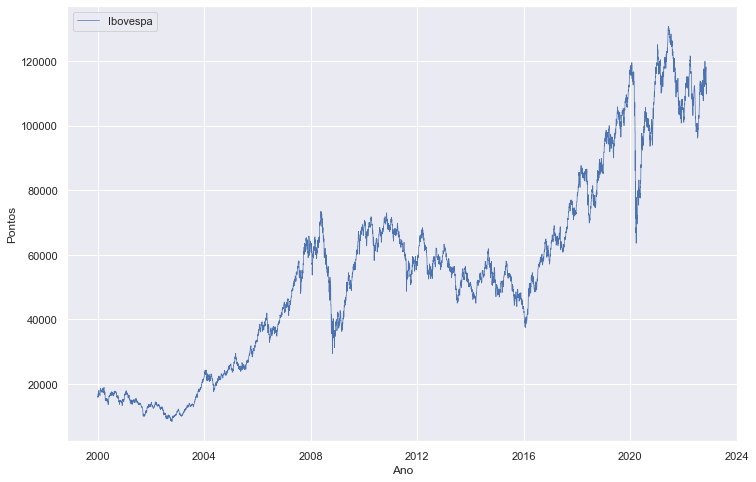

In [18]:
# Série do Ibovespa graficamente
plt.plot(ibov['IBOV'], label = 'Ibovespa', linewidth =.7)
plt.xlabel("Ano")
plt.ylabel("Pontos")
plt.xticks(fontname = "Arial")
plt.legend()
plt.show()

In [19]:
# vai retornar o dataframe do ibovespa com valores trimestrais apenas
ibov = ibov.loc[quarters]

Os retornos trimestrais anualizados do Ibovespa podem ser obtidos através da seguinte equação

$$
r_t^e = \frac{P_{t} - P_{t-1}}{P_{t-1}}
$$

$$
r_e^{anualizado} = \left(1+ r_t^e\right)^4-1
$$

In [20]:
ibov['IBOV_{t-1}'] = ibov['IBOV'].shift(1)

In [21]:
ibov['re'] = (1 + ((ibov['IBOV'] - ibov['IBOV_{t-1}'])/ibov['IBOV_{t-1}']))**4 - 1

In [22]:
ibov.head(10)

,IBOV,IBOV_{t-1},re
2012-06-30,54355.0,NaN,NaN
2012-09-30,59176.0,54355.0,0.404832
2012-12-31,60952.0,59176.0,0.125562
2013-03-31,56352.0,60952.0,-0.269390
2013-06-30,47457.0,56352.0,-0.497005
2013-09-30,52338.0,47457.0,0.479338
2013-12-31,51507.0,52338.0,-0.062014
2014-03-31,50415.0,51507.0,-0.082145
2014-06-30,53168.0,50415.0,0.236979
2014-09-30,54116.0,53168.0,0.073251


In [23]:
ibov['IPCA'] = ipca['IPCA_a']

Para obtermos a rentabilidade da equity em termos reais temos que

$$
r_e^{\$} = \frac{1+r_e}{1+\pi} - 1
$$

In [24]:
ibov['re_real'] = ((1+ibov['re'])/(1+ibov['IPCA'])) - 1

In [25]:
ibov = ibov[:-1]

In [26]:
ibov.head(10)

,IBOV,IBOV_{t-1},re,IPCA,re_real
2012-06-30,54355.0,NaN,NaN,NaN,NaN
2012-09-30,59176.0,54355.0,0.404832,0.057878,0.327972
2012-12-31,60952.0,59176.0,0.125562,0.082134,0.040132
2013-03-31,56352.0,60952.0,-0.269390,0.079974,-0.323493
2013-06-30,47457.0,56352.0,-0.497005,0.048226,-0.520146
2013-09-30,52338.0,47457.0,0.479338,0.025073,0.443154
2013-12-31,51507.0,52338.0,-0.062014,0.084272,-0.134916
2014-03-31,50415.0,51507.0,-0.082145,0.089890,-0.157846
2014-06-30,53168.0,50415.0,0.236979,0.062938,0.163736
2014-09-30,54116.0,53168.0,0.073251,0.033677,0.038285


### Futuro DI com um mês

In [27]:
futurodi = pd.read_csv('futuroDI.csv', sep=',', index_col=0)

In [28]:
# função que torna o índice um objeto de data
futurodi.index = pd.to_datetime(futurodi.index)

In [29]:
# normalizando os dados que estavam em taxas para números decimais
futurodi = futurodi/100

In [30]:
futurodi = futurodi[['BRPRE1M=BMF']]

In [31]:
futurodi = futurodi.rename(columns={'BRPRE1M=BMF':'rf'})

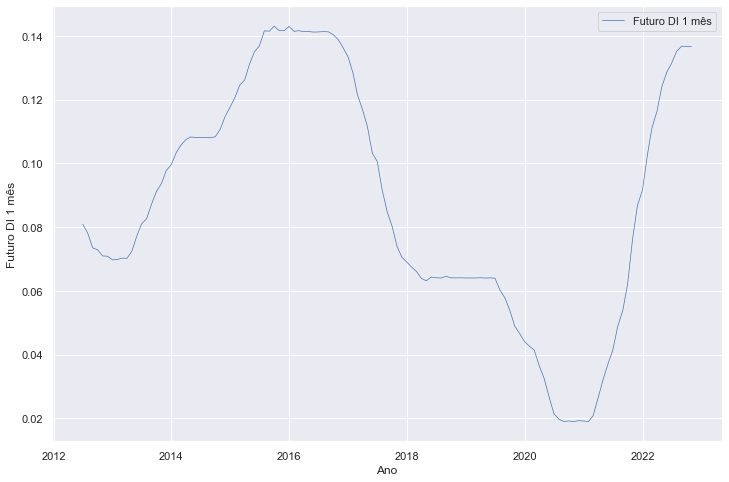

In [32]:
# Série do futuro DI graficamente
plt.plot(futurodi['rf'], label = 'Futuro DI 1 mês', linewidth =.7)
plt.xlabel("Ano")
plt.ylabel("Futuro DI 1 mês")
plt.xticks(fontname = "Arial")
plt.legend()
plt.show()

In [33]:
futurodi = futurodi[::-1]

In [34]:
futurodi = futurodi.loc[quarters]

In [35]:
futurodi.head(10)

,rf
2012-06-30,0.08089
2012-09-30,0.07293
2012-12-31,0.06974
2013-03-31,0.07021
2013-06-30,0.08104
2013-09-30,0.09118
2013-12-31,0.09957
2014-03-31,0.10743
2014-06-30,0.10814
2014-09-30,0.10835


In [36]:
futurodi['IPCA'] = ipca['IPCA_a']

Da mesma forma para o short-term interest rate, para obtermos a rentabilidade em termos reais temos que

$$
r_f^{\$} = \frac{1+r_f}{1+\pi} - 1
$$

In [37]:
futurodi['rf_real'] = ((1+futurodi['rf'])/(1+futurodi['IPCA'])) - 1

In [38]:
futurodi = futurodi[:-1]

In [39]:
futurodi.head(10)

,rf,IPCA,rf_real
2012-06-30,0.08089,NaN,NaN
2012-09-30,0.07293,0.057878,0.014229
2012-12-31,0.06974,0.082134,-0.011453
2013-03-31,0.07021,0.079974,-0.009041
2013-06-30,0.08104,0.048226,0.031305
2013-09-30,0.09118,0.025073,0.064490
2013-12-31,0.09957,0.084272,0.014109
2014-03-31,0.10743,0.089890,0.016093
2014-06-30,0.10814,0.062938,0.042526
2014-09-30,0.10835,0.033677,0.072240


### Consumo Real per capita Desazonalizado

In [40]:
consumo = pd.read_csv('real_consumption_seasonally_adjusted.csv', sep=',', index_col=0)
pop = pd.read_csv('population.csv', sep=',', index_col=0)

In [41]:
# função que torna o índice um objeto de data
consumo.index = pd.to_datetime(consumo.index)
pop.index = pd.to_datetime(pop.index)

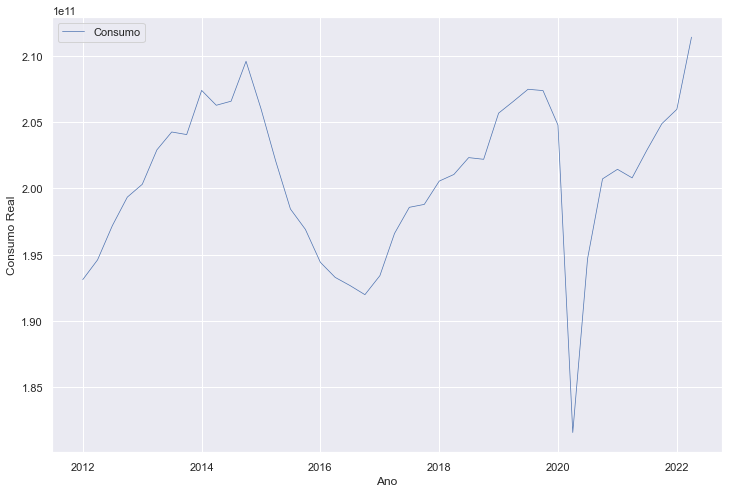

In [42]:
# Série do Consumo graficamente
plt.plot(consumo['NAEXKP02BRQ189S'], label = 'Consumo', linewidth =.7)
plt.xlabel("Ano")
plt.ylabel("Consumo Real")
plt.xticks(fontname = "Arial")
plt.legend()
plt.show()

In [43]:
quarters_ = consumo.index

In [44]:
pop = pd.DataFrame(pop, index = quarters_)

In [45]:
pop.head(10)

,POPTOTBRA647NWDB
DATE,
2012-01-01,199287292.0
2012-04-01,NaN
2012-07-01,NaN
2012-10-01,NaN
2013-01-01,201035904.0
2013-04-01,NaN
2013-07-01,NaN
2013-10-01,NaN
2014-01-01,202763744.0


Como os dados de população são ofertados apenas com periodicidade anual, vamos supor que o crescimento trimestral $\Delta L_t / L_t$ foi uniforme, isto é, mesma taxa de crescimento entre os trimestres:

$$
\frac{\Delta L_{t}}{L_t} = \left(1+\frac{\Delta L_{4t}}{L_{4t}}\right)^{\frac{1}{4}} - 1
$$

onde 

$$
\frac{\Delta L_{4t}}{L_{4t}}
$$

é a taxa de crescimento populacional anual.

Uma outra ressalva é que os dados populacionais vão até o primeiro trimestre de 2021. Teremos então que a população estimada para os trimestres posteriores serão a partir da taxa de crescimento entre 2020 e 2021 e a população constatada em 2021.

In [46]:
pop['POP_{t-1}'] = pop['POPTOTBRA647NWDB'].shift(4)

In [47]:
pop['taxa_anual'] = (pop['POPTOTBRA647NWDB'] - pop['POP_{t-1}'])/pop['POP_{t-1}']

In [48]:
pop['taxa_trimestral'] = np.nan

In [49]:
for i in range(len(pop)):
    if math.isnan(pop['taxa_anual'][i]) == False:
        pop['taxa_trimestral'][i-1] = (1 + pop['taxa_anual'][i])**(1/4) - 1        
        pop['taxa_trimestral'][i-2] = (1 + pop['taxa_anual'][i])**(1/4) - 1
        pop['taxa_trimestral'][i-3] = (1 + pop['taxa_anual'][i])**(1/4) - 1
        pop['taxa_trimestral'][i-4] = (1 + pop['taxa_anual'][i])**(1/4) - 1
    else:
        continue

In [50]:
normalize_nan(pop['taxa_trimestral'])

In [51]:
pop['pop_estimada'] = np.nan

In [52]:
for i in range(len(pop)):
    if math.isnan(pop['POPTOTBRA647NWDB'][i]) == False:
        pop['pop_estimada'][i] = pop['POPTOTBRA647NWDB'][i]
    else:
        pop['pop_estimada'][i] = pop['pop_estimada'][i-1]*(1+pop['taxa_trimestral'][i-1])

In [53]:
pop.head(10)

,POPTOTBRA647NWDB,POP_{t-1},taxa_anual,taxa_trimestral,pop_estimada
DATE,,,,,
2012-01-01,199287292.0,NaN,NaN,0.002186,1.992873e+08
2012-04-01,NaN,NaN,NaN,0.002186,1.997230e+08
2012-07-01,NaN,NaN,NaN,0.002186,2.001597e+08
2012-10-01,NaN,NaN,NaN,0.002186,2.005973e+08
2013-01-01,201035904.0,199287292.0,0.008774,0.002142,2.010359e+08
2013-04-01,NaN,NaN,NaN,0.002142,2.014665e+08
2013-07-01,NaN,NaN,NaN,0.002142,2.018980e+08
2013-10-01,NaN,NaN,NaN,0.002142,2.023304e+08
2014-01-01,202763744.0,201035904.0,0.008595,0.002099,2.027637e+08


In [54]:
consumo['pop'] = pop['pop_estimada']

In [55]:
consumo['consumo_percapita'] = consumo['NAEXKP02BRQ189S']/consumo['pop']

A taxa de crescimento bruta do consumo pode ser obtida através de

$$
\Delta c_t = \left(\frac{c_t}{c_{t-1}}\right)
$$

onde $c_t$ é o consumo per capita em $t$.

In [56]:
consumo['consumo_percapita_{t-1}'] = consumo['consumo_percapita'].shift(1)

In [57]:
consumo['Delta_c'] = consumo['consumo_percapita']/consumo['consumo_percapita_{t-1}']

Como 2012-04-01 representa o consumo no segundo trimetre de 2012 no dataframe de consumo e 2012-06-30 representa o fechamento do Ibovespa do segundo trimestre de 2012. Então temos que as datas estão representando períodos diferentes entre os dataframes. Vamos normalizar isso

In [58]:
consumo = consumo[1:]

In [59]:
# normalizando o índice para os três dataframes ficarem iguais
consumo['index'] = ibov.index

In [60]:
consumo = consumo.set_index('index')

In [61]:
consumo.head(10)

,NAEXKP02BRQ189S,pop,consumo_percapita,consumo_percapita_{t-1},Delta_c
index,,,,,
2012-06-30,1.946165e+11,1.997230e+08,974.432202,969.080023,1.005523
2012-09-30,1.971950e+11,2.001597e+08,985.188204,974.432202,1.011038
2012-12-31,1.993447e+11,2.005973e+08,993.755424,985.188204,1.008696
2013-03-31,2.003120e+11,2.010359e+08,996.399101,993.755424,1.002660
2013-06-30,2.029082e+11,2.014665e+08,1007.156136,996.399101,1.010796
2013-09-30,2.042542e+11,2.018980e+08,1011.670265,1007.156136,1.004482
2013-12-31,2.040599e+11,2.023304e+08,1008.547673,1011.670265,0.996913
2014-03-31,2.073897e+11,2.027637e+08,1022.814570,1008.547673,1.014146
2014-06-30,2.062680e+11,2.031894e+08,1015.151529,1022.814570,0.992508


### DataFrame final

In [62]:
df = pd.DataFrame(index = ibov.index)

In [63]:
df['r_e'] = ibov['re_real']
df['r_f'] = futurodi['rf_real']
df['Delta_c'] = consumo['Delta_c']

In [64]:
df.head(10)

,r_e,r_f,Delta_c
2012-06-30,NaN,NaN,1.005523
2012-09-30,0.327972,0.014229,1.011038
2012-12-31,0.040132,-0.011453,1.008696
2013-03-31,-0.323493,-0.009041,1.002660
2013-06-30,-0.520146,0.031305,1.010796
2013-09-30,0.443154,0.064490,1.004482
2013-12-31,-0.134916,0.014109,0.996913
2014-03-31,-0.157846,0.016093,1.014146
2014-06-30,0.163736,0.042526,0.992508
2014-09-30,0.038285,0.072240,0.999389


Vamos definir função critério $J(\beta,\gamma)$ com:

Momento populacional

$$
\operatorname{argmax}_{\beta, \gamma} J(\beta, \gamma)=\mathbb{E}\left(g(\beta, \gamma)^{\prime}\right) W \mathbb{E}\left(g(\beta, \gamma)\right).
$$

Momentos amostrais:

$$
\operatorname{argmax}_{\beta, \gamma} J(\beta, \gamma)=\frac{1}{T} \times \bar{g}_T(\beta, \gamma)^{\prime} W \bar{g}_T(\beta, \gamma)
$$

where
- $\beta$ é o fator de desconto temporal.
- $\gamma$ é o coeficiênte de aversão relativa ao risco.
- $\bar{g}_T$ é o momento amostral.
- $W$ é a matriz de ponderação. Como o intuito dessa matriz é ganhar eficiência, usaremos a matriz identidade a priori $W = I$.

Partiremos do Valor Presente Descontado sob a condição de não arbitragem 

$$
\mathbb{E}_t[M_{t+1,t} R_{t+1}^j] = 1
\tag{1}
$$

onde $M_{t+1,t}$ representa o fator estocástico de desconto e $R_{t+1}^j$ o retorno bruto do ativo $j$, enquanto $t=1,...,T$ denota o período coberto trimestralmente. 

Substituindo dentro da equação $(1)$ o fator estocástico de desconto $M_{t+1,t} = \beta\frac{u'(c_{t+1})}{u'(c_t)}$ chegamos que


$$
\mathbb{E}_t \left[\beta\frac{u'(c_{t+1})}{u'(c_t)} R_{t+1}^j\right] = 1
$$

$$
\mathbb{E}_t \left[\beta\frac{u'(c_{t+1})}{u'(c_t)} R_{t+1}^j - 1 \right] = 0
$$

onde o subscrito $t$ no operador da esperança significa condicional ao conjunto informacional em $t$. Denote por $\mathcal{F}_t$ tal conjunto informacional.

$$
\mathbb{E} \left[\beta\frac{u'(c_{t+1})}{u'(c_t)} R_{t+1}^j - 1 \;\middle|\; \mathcal{F}_t \right] = 0
$$

Queremos incorporar o conjunto informacional para que tenhamos uma esperança incondicional. Vamos modelar com "instrumentos". Supondo que $Z_t$ modela o conjunto informacional $\mathcal{F}_t$.

$$
\mathbb{E} \left[\beta\frac{u'(c_{t+1})}{u'(c_t)} R_{t+1}^j - 1 \;\middle|\; Z_t \right] = 0
\tag{2}
$$

$$
\Rightarrow \mathbb{E} \left[\beta\frac{u'(c_{t+1})}{u'(c_t)} R_{t+1}^j - 1 \;\middle|\; Z_t \right] \otimes Z_t = 0
$$

onde $\otimes$ denota o produto de Kronecker.


$$
\Rightarrow \mathbb{E} \left[\beta\frac{u'(c_{t+1})}{u'(c_t)} R_{t+1}^j \otimes Z_t - 1 \otimes Z_t \;\middle|\; Z_t \right] = 0
$$

Podemos tirar o condicional e chegamos (a proof dessa passagem está na próxima celula).

$$
\Rightarrow \mathbb{E} \left[\beta\frac{u'(c_{t+1})}{u'(c_t)} R_{t+1}^j \otimes Z_t - 1 \otimes Z_t \right] = 0
\tag{3}
$$

onde a equação $(3)$ representa a condição de momento populacional. 

Proof) Tome a lei das expectativas iteradas na equação $(3)$:

$$
\mathbb{E} \left[\left(\beta \frac{u'(c_{t+1})}{u'(c_t)} R_{t+1}^j - 1\right) \otimes Z_t\right] = 0
$$

$$
\Rightarrow \mathbb{E} \left( \mathbb{E} \left[\left(\beta \frac{u'(c_{t+1})}{u'(c_t)} R_{t+1}^j - 1\right) \otimes Z_t \;\middle|\; Z_t \right] \right) = 0
$$

distribuindo o condicional

$$
\Rightarrow \mathbb{E} \left( \mathbb{E} \left[ \left( \beta \frac{u'(c_{t+1})}{u'(c_t)} R_{t+1}^j - 1 \right) \;\middle|\; Z_t  \otimes \underbrace{Z_t \mid Z_t}_{Z_t \mid Z_t=Z_t} \right] \right) = 0
$$


$$
\Rightarrow \mathbb{E} \left( \left[ \underbrace{\mathbb{E} \left( \beta \frac{u'(c_{t+1})}{u'(c_t)} R_{t+1}^j - 1 \;\middle|\; Z_t \right)}_{= 0} \otimes Z_t \right] \right) = 0
$$

onde a esperança de dentro é zero pela equação $(2)$

In [65]:
# retornos brutos
df['R_e'] = 1 + df['r_e']
df['R_f'] = 1 + df['r_f']

Precisamos agora, definir quem são os elementos do conjunto informacional $Z_t$. Vamos definir como uma constante, taxa de crescimento real do consumo per capita defasada em um trimestre $\Delta c_{t}$, retorno bruto trimestral do Ibovespa defasado em um trimestre $R_{t}^i$ e a taxa bruta do futuro DI de 1 mês defasado em um trimestre $R_{t}^f$.

$$
Z_t = \left[1, \Delta c_{t}, R_{t}^i, R_{t}^f \right]
$$

In [129]:
# instrumentos
df['1'] = -10
df['Delta_c_1'] = df['Delta_c'].shift(1)
df['R_e_1'] = df['R_e'].shift(1)
df['R_f_1'] = df['R_f'].shift(1)

In [130]:
df = df.dropna()

In [131]:
df.head(10)

,r_e,r_f,Delta_c,R_e,R_f,1,Delta_c_1,R_e_1,R_f_1
2013-09-30,0.443154,0.064490,1.004482,1.443154,1.064490,-10,1.010796,0.479854,1.031305
2013-12-31,-0.134916,0.014109,0.996913,0.865084,1.014109,-10,1.004482,1.443154,1.064490
2014-03-31,-0.157846,0.016093,1.014146,0.842154,1.016093,-10,0.996913,0.865084,1.014109
2014-06-30,0.163736,0.042526,0.992508,1.163736,1.042526,-10,1.014146,0.842154,1.016093
2014-09-30,0.038285,0.072240,0.999389,1.038285,1.072240,-10,0.992508,1.163736,1.042526
2014-12-31,-0.318909,0.044004,1.012441,0.681091,1.044004,-10,0.999389,1.038285,1.072240
2015-03-31,-0.058100,-0.030969,0.980856,0.941900,0.969031,-10,1.012441,0.681091,1.044004
2015-06-30,0.060733,0.039710,0.978932,1.060733,1.039710,-10,0.980856,0.941900,0.969031
2015-09-30,-0.508573,0.081782,0.980015,0.491427,1.081782,-10,0.978932,1.060733,1.039710
2015-12-31,-0.233365,0.022752,0.990218,0.766635,1.022752,-10,0.980015,0.491427,1.081782


In [132]:
# coletando os dados

Z = df[['1', 'R_e_1', 'R_f_1', 'Delta_c_1']].values
DeltaC = df['Delta_c'].values.tolist()
R_e = df['R_e'].values.tolist()
R_f = df['R_f'].values.tolist()

Sob a hipótese de utilidade CRRA (Constant Relative Risk Aversion)

$$
U(c) = \sum_{t=0}^T \beta^t\frac{c_t^{1-\gamma}}{1-\gamma}
$$

temos então que

$$
u(c_t) = \frac{c_t^{1-\gamma}}{1-\gamma}
$$

e então

$$
u'(c_t) = c_t^{-\gamma}
$$

Portanto, a condição de momento populacional se torna

$$
\mathbb{E} \left[\left(\beta\left(\frac{c_{t+1}}{c_t}\right)^{-\gamma} R_{t+1}^j - 1 \right)\otimes Z_t \right] = 0
$$

In [133]:
# equação de valor presente descontado sob não arbitragem (Equação de Euler)

VPL = np.zeros(len(df))

def VPL_function(beta, gamma, R):
    for t in range(len(df)):
        VPL[t] = (beta*(DeltaC[t]**(-gamma))*R[t]) - 1
    
    return VPL

Temos então que o momento amostral é definido como

$$
\bar{g}_T' = \frac{1}{T}\sum_{t=0}^T \underbrace{\left( \underbrace{\left[\beta \left(\frac{c_{t+1}}{c_t}\right)^{-\gamma} R_{t+1}^j - 1 \right]}_{1\operatorname{x}1} \otimes \underbrace{\left[1, \Delta c_{t}, r_{t}^i, r_{t}^f \right]}_{1\operatorname{x}4} \right)}_{1\otimes 4 = 1\operatorname{x}4}
$$

In [134]:
T = len(df)

def g(beta, gamma, R):

    temp_matrix = np.zeros((len(df), len(Z.T)))

    VPL = np.array(VPL_function(beta, gamma, R))
    
    for t in range(T):
        temp_matrix[t] = np.kron(VPL[t], Z[t,:])
    
    g = (1/T)*temp_matrix.sum(axis=0)

    return g

Assim, ficamos com uma função critério 

$$
\underbrace{J(\beta,\gamma)}_{1\operatorname{x}1} = T \cdot \underbrace{\bar{g}_T'}_{1\operatorname{x}4} \underbrace{W}_{4\operatorname{x}4} \underbrace{\bar{g}_T}_{4\operatorname{x}1}
$$

In [135]:
def J(x, R):
    
    beta = x[0]
    gamma = x[1]

    g_T = g(beta, gamma, R)

    W = np.identity(len(g_T))
    
    J = T*(np.matmul(np.matmul(g_T, W), g_T.T))

    return J

In [136]:
res = minimize(J, [0 , 0], args = (R_e), method='Nelder-Mead', options={'xatol': 1e-7, 'disp': True, 'maxiter': 10000})

Optimization terminated successfully.
         Current function value: 0.000224
         Iterations: 144
         Function evaluations: 267


In [137]:
print('beta', res.x[0], 'gamma', res.x[1])

beta 0.8757628469383409 gamma -10.735168977155492


In [138]:
res = minimize(J, [0, 0], args = (R_f), method='Nelder-Mead', options={'xatol': 1e-7, 'disp': True, 'maxiter': 10000})

Optimization terminated successfully.
         Current function value: 0.000058
         Iterations: 113
         Function evaluations: 217


In [139]:
print('beta', res.x[0], 'gamma', res.x[1])

beta 0.9777027283921496 gamma -0.4334804751193446


Podemos também utilizar as funções prontas de python para avaliar os resultados. Utilizando a metodologia da função pronta, temos também o resultado do teste J de Hansen.

In [125]:
def moment_consumption1(params, exog):
    beta, gamma = params
    R, DeltaC = exog.T  
    
    err = 1 - beta * R * np.power(DeltaC, -gamma)
    return -err

In [126]:
exog1 = df[['R_e', 'Delta_c']].values
exog2 = df[['R_f', 'Delta_c']].values

In [127]:
endog1 = np.zeros(len(df))    
mod1 = gmm.NonlinearIVGMM(endog1, exog1, Z, moment_consumption1, k_moms=4)
w0inv = np.identity(4)
res1 = mod1.fit([1,-1], maxiter=2, inv_weights=w0inv) 

Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 17
         Function evaluations: 23
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 0.047038
         Iterations: 7
         Function evaluations: 12
         Gradient evaluations: 12


In [128]:
print(res1.summary(yname='Euler Eq', xname=['discount', 'CRRA']))

                            NonlinearIVGMM Results                            
Dep. Variable:               Euler Eq   Hansen J:                        1.740
Model:                 NonlinearIVGMM   Prob (Hansen J):                 0.419
Method:                           GMM                                         
Date:                Mon, 14 Nov 2022                                         
Time:                        18:46:44                                         
No. Observations:                  37                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
discount       0.8943      0.055     16.130      0.000       0.786       1.003
CRRA          -6.3550      3.124     -2.034      0.042     -12.477      -0.233


In [97]:
endog1 = np.zeros(len(df))    
mod1 = gmm.NonlinearIVGMM(endog1, exog2, Z, moment_consumption1, k_moms=4)
w0inv = np.identity(4)
res1 = mod1.fit([1,-1], maxiter=2, inv_weights=w0inv)

Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 4
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.229207
         Iterations: 6
         Function evaluations: 9
         Gradient evaluations: 9


In [98]:
print(res1.summary(yname='Euler Eq', xname=['discount', 'CRRA']))

                            NonlinearIVGMM Results                            
Dep. Variable:               Euler Eq   Hansen J:                        8.939
Model:                 NonlinearIVGMM   Prob (Hansen J):                0.0115
Method:                           GMM                                         
Date:                Mon, 14 Nov 2022                                         
Time:                        18:44:05                                         
No. Observations:                  39                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
discount       0.9777      0.006    156.954      0.000       0.966       0.990
CRRA          -0.2075      0.506     -0.410      0.682      -1.199       0.784
